Start With Geting Torch and check on our GPU


In [2]:
import torch
torch.__version__

'2.1.0+cu118'

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070'

In [3]:

MODEL_ARCH = 'yolo_nas_l'  # model name
BATCH_SIZE = 12  # how many images the model see at once
MAX_EPOCHS = 5  # max trining epocs : how many times the model see the image
EPOCHS = 5
CHECKPOINT_DIR = '/checkpoints'  # output folder path
EXPERIMENT_NAME = "Chess_Pieces"  # name of our project model

In [4]:

from super_gradients.training import Trainer

# set trainer
trainer = Trainer(experiment_name=EXPERIMENT_NAME,
                  ckpt_root_dir=CHECKPOINT_DIR)

In [5]:
# data params for data dir and path for each folder and the classes

dataset_params = {


    'data_dir': 'D:\codewello\yolo-nas\Chess Pieces',
    'train_images_dir': 'train\images',
    'train_labels_dir': 'train\labels',


    'val_images_dir': 'valid\images',
    'val_labels_dir': 'valid\labels',
    'test_images_dir': 'test\images',
    'test_labels_dir': 'test\labels',


    'classes': ['bishop', 'black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']


}

In [6]:
# Importing Data Loaders: traning and valdition
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

# Setting up Training Data Loader
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

Indexing dataset annotations: 100%|██████████| 58/58 [00:00<00:00, 4833.20it/s]


Indexing dataset annotations: 100%|██████████| 29/29 [00:00<00:00, 4143.30it/s]


#Now inspect the dataset defined earlier. 😊

SuperGradients added transforms for you.
You're free to experiment with these transformations as you please.
You can also add in your own transformations from torchvision.transforms, albumentations or a custom tranformaton.


In [7]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [8]:
# The transforms are in a dictionary, so you'll need to slice it to modify.

train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

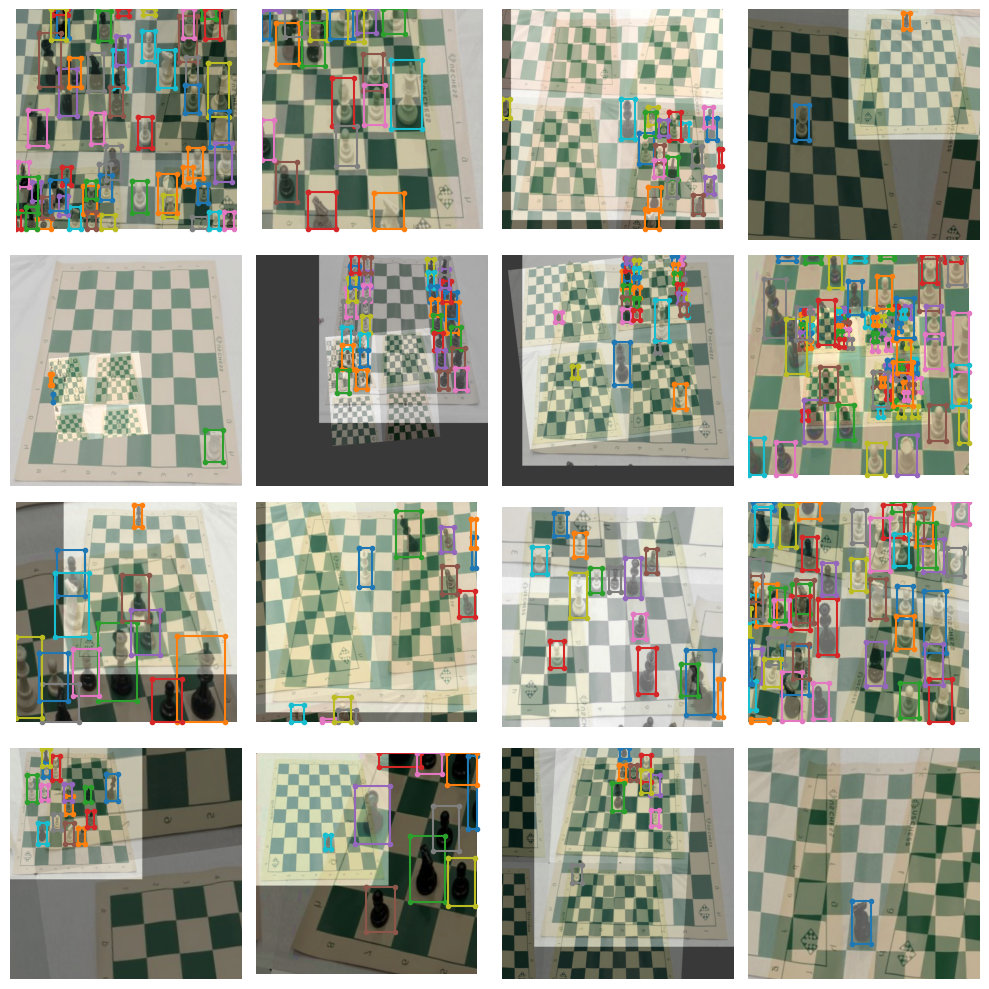

In [9]:
train_data.dataset.plot()

#Setup the model we want to use


In [10]:

from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

In [11]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

#Set The Train Params

max_epochs - Max number of training epochs

loss - the loss function you want to use

optimizer - Optimizer you will be using

train_metrics_list - Metrics to log during training

valid_metrics_list - Metrics to log during training

metric_to_watch - metric which the model checkpoint will be saved according to


In [12]:
train_params = {
    # ENABLING SILENT MODE SET True if you want
    'silent_mode': False,
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

#Start Training our model


In [13]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

d:\codewello\yolo-nas\myvenv\lib\site-packages\super_gradients\common\registry\registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
d:\codewello\yolo-nas\myvenv\lib\site-packages\super_gradients\training\utils\optimizer_utils.py:107: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
Validating epoch 10: 100%|██████████| 5/5 [00:36<00:00,  7.20s/it]


In [13]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="D:\checkpoints\Chess_Pieces\RUN_20231227_102912_085238\ckpt_best.pth")
# checkpoint_path="checkpoints/my_first_yolonas_run/average_model.pth")

In [15]:
trainer.test(model=best_model,
             test_loader=test_data,
             test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                    top_k_predictions=300,
                                                    num_cls=len(
                                                        dataset_params['classes']),
                                                    normalize_targets=True,
                                                    post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                           nms_top_k=1000,
                                                                                                           max_predictions=300,
                                                                                                           nms_threshold=0.7)
                                                    ))

Testing: 100%|██████████| 3/3 [00:19<00:00,  5.60s/it]

{'PPYoloELoss/loss_cls': 0.5921855,
 'PPYoloELoss/loss_iou': 0.3228917,
 'PPYoloELoss/loss_dfl': 0.3438255,
 'PPYoloELoss/loss': 1.2589028,
 'Precision@0.50': 0.28929245471954346,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.992720901966095,
 'F1@0.50': 0.4349282681941986}

Testing: 100%|██████████| 3/3 [00:20<00:00,  6.80s/it]


_what it mean?_

Losses:

loss_cls: Measures how well the model classifies objects.
loss_iou: Evaluates how accurately the model localizes objects.
loss_dfl: Reflects the precision of object localization.
loss: Overall loss the model is trying to minimize during training.
Performance Metrics:

Precision@0.50: Percentage of correctly predicted positive instances.
Recall@0.50: Percentage of actual positive instances correctly predicted.
mAP@0.50: Mean Average Precision, a combination of precision and recall.
F1@0.50: Harmonic mean of precision and recall.


##Run Detection on image link


Predicting Images: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


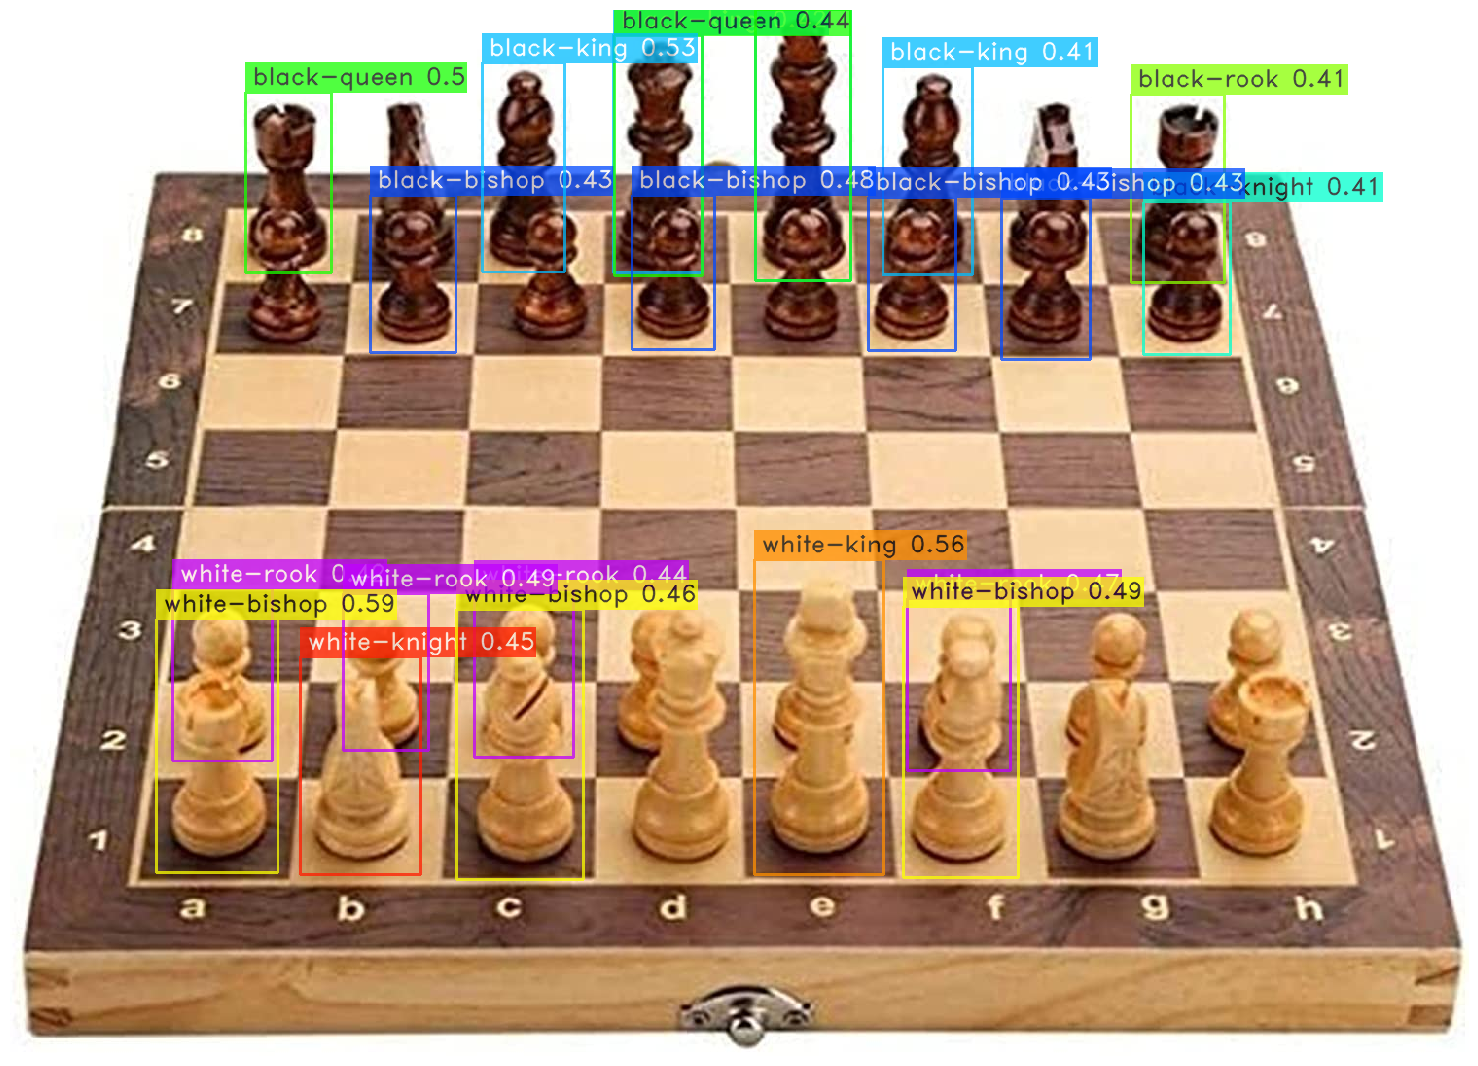

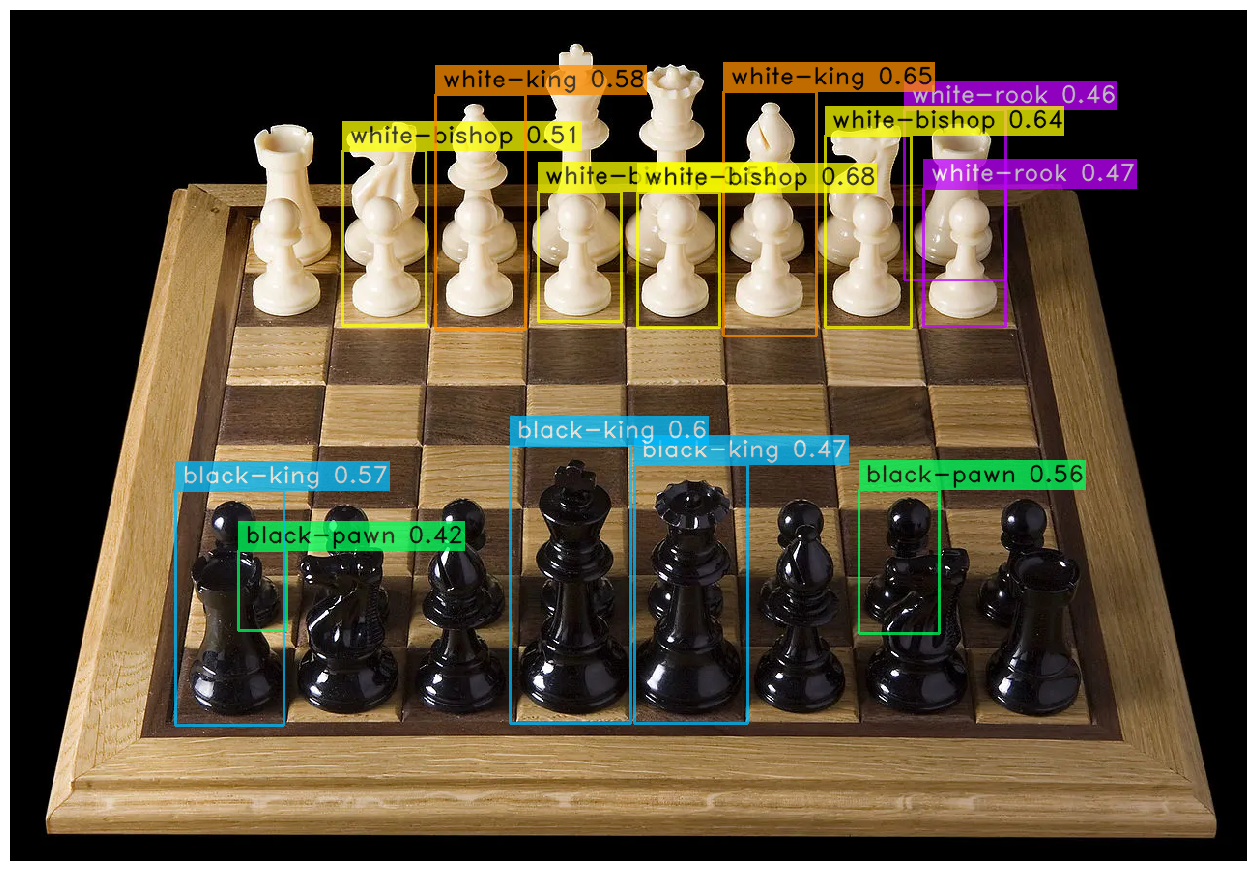

In [14]:
Images = ['https://m.media-amazon.com/images/I/61omIL8-wlL.jpg',
          'https://th-thumbnailer.cdn-si-edu.com/B_i-VRRsC3tYBtu-MgPlr_yACT8=/fit-in/1600x0/https%3A%2F%2Ftf-cmsv2-smithsonianmag-media.s3.amazonaws.com%2Ffiler%2F5e%2F20%2F5e20f146-9fe0-4937-9068-2ed746676d70%2F10-a-game-designer.jpg']


images_predications = best_model.predict(Images, iou=0.5, conf=0.4).show()

# images_predications.save(output_folder="./predicate_images",
# box_thickness=2, show_confidence=True)

In [ ]:
for image_prediction in images_predications:
    class_names = image_prediction.class_names
    labels = image_prediction.prediction.labels
    confidence = image_prediction.prediction.confidence
    bboxes = image_prediction.prediction.bboxes_xyxy

    for i, (label, conf, bbox) in enumerate(zip(labels, confidence, bboxes)):
        print("prediction: ", i)
        print("label_id: ", label)
        print("label_name: ", class_names[int(label)])
        print("confidence: ", conf)
        print("bbox: ", bbox)
        print("--" * 10)

        # You can use the detection results for various tasks, such as:
        # - Filtering objects based on confidence scores or labels
        # - Analyzing object distributions within the images
        # - Calculating object dimensions or areas
        # - Implementing custom visualization techniques
        # - ...

#Run Detection on video using our best model


In [22]:


import torch
device = 0 if torch.cuda.is_available() else "cpu"

input_video_path = "D:\codewello\yolo-nas\one.mp4"
output_video_path = "detections_one.mp4"
# device=0

best_model.to(device).predict(input_video_path).save(output_video_path)

Processing Video:  94%|█████████▍| 221/234 [01:37<00:02,  4.41it/s]

Processing Video: 100%|██████████| 234/234 [01:42<00:00,  2.29it/s]


In [19]:
%pip install onemetric superivison

In [25]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path="D:/codewello/yolo-nas/Chess Pieces/test/images",
    annotations_directory_path="D:/codewello/yolo-nas/Chess Pieces/test/labels",
    data_yaml_path="D:/codewello/yolo-nas/Chess Pieces/data.yaml",
    force_masks=False
)

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

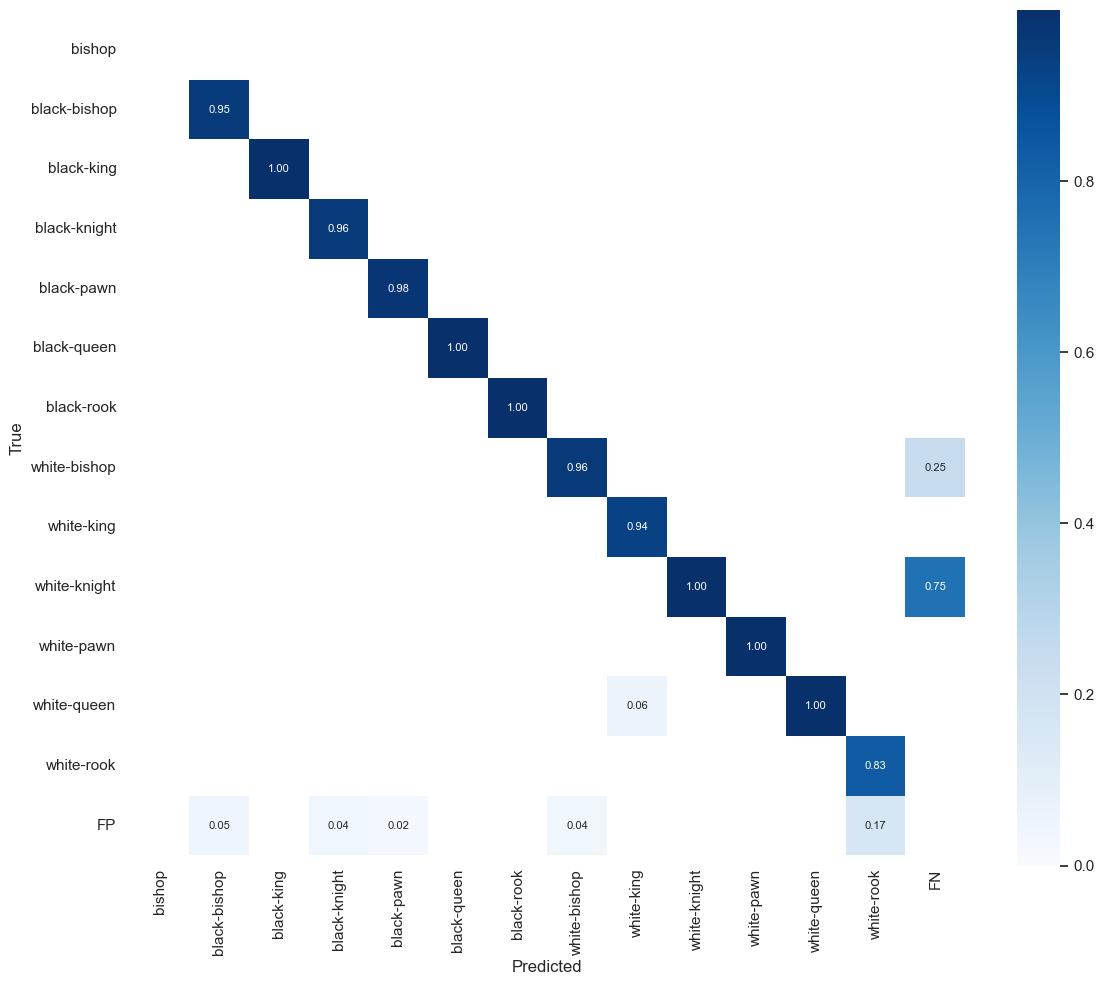

In [26]:
import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation = ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction = predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join("D:\codewello\yolo-nas",
                      "confusion_matrix.png"), class_names=ds.classes)